In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0

     |████████████████████████████████| 4.9 MB 4.8 MB/s 
     |████████████████████████████████| 462 kB 49.1 MB/s 
     |████████████████████████████████| 1.8 MB 9.2 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 99 kB 10.5 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 234 kB 49.0 MB/s 
     |████████████████████████████████| 352 kB 64.7 MB/s 
     |████████████████████████████████| 1.2 MB 53.2 MB/s 
     |████████████████████████████████| 47.7 MB 77 kB/s 
     |████████████████████████████████| 1.1 MB 40.2 MB/s 


In [2]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd drive/MyDrive/Colab Notebooks/AdvancedNLP

/content/drive/MyDrive/Colab Notebooks/AdvancedNLP


In [6]:
synonyms_corpus = pd.read_csv('train.csv')

synonyms_corpus.head()

# [8] checking the percentage of majority class and selecting accuracy as evaluation metric
label, count = np.unique(synonyms_corpus['LABEL'].values, return_counts=True)
print(max(count)/sum(count))

synonyms_corpus = synonyms_corpus.fillna('none')

0.47058823529411764


In [136]:
test_corpus = pd.read_csv('eval.csv')

print(test_corpus.head())

# [8] checking the percentage of majority class and selecting accuracy as evaluation metric
label, count = np.unique(test_corpus['ANNOTATED'].values, return_counts=True)
print(max(count)/sum(count))

test_corpus = test_corpus.fillna('none')

np.unique(test_corpus['ANNOTATED'].values, return_counts=True)

      LEMMA 1  ... LABEL
0  peripteral  ...   NaN
1  peripteral  ...   NaN
2      manual  ...   NaN
3   following  ...   NaN
4      better  ...   NaN

[5 rows x 8 columns]
0.32038834951456313


(array(['equivalent', 'less intense', 'less specific', 'more intense',
        'more specific', 'related'], dtype=object),
 array([22,  4,  5, 18, 33, 21]))

In [8]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [10]:
def1_preprocessed = bert_preprocess_model(synonyms_corpus['DEFINITION 1'])
def2_preprocessed = bert_preprocess_model(synonyms_corpus['DEFINITION 2'])
ex1_preprocessed = bert_preprocess_model(synonyms_corpus['EXAMPLE 1'])
ex2_preprocessed = bert_preprocess_model(synonyms_corpus['EXAMPLE 2'])

In [137]:
#test
test_def1_preprocessed = bert_preprocess_model(test_corpus['DEFINITION 1'])
test_def2_preprocessed = bert_preprocess_model(test_corpus['DEFINITION 2'])
test_ex1_preprocessed = bert_preprocess_model(test_corpus['EXAMPLE 1'])
test_ex2_preprocessed = bert_preprocess_model(test_corpus['EXAMPLE 2'])

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
def1 = bert_model(def1_preprocessed)
def2 = bert_model(def2_preprocessed)
ex1 = bert_model(ex1_preprocessed)
ex2 = bert_model(ex2_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1


In [138]:
test_def1 = bert_model(test_def1_preprocessed)
test_def2 = bert_model(test_def2_preprocessed)
test_ex1 = bert_model(test_ex1_preprocessed)
test_ex2 = bert_model(test_ex2_preprocessed)


In [13]:
import gensim.downloader as api
word_vectors = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [14]:
from nltk import word_tokenize
from nltk.corpus import stopwords
import string

exclusions = [list(string.punctuation), '``', "''"]

def preprocess_sent(sentence):
    words = []
    if not sentence != sentence:
        for word in word_tokenize(sentence):
            word = word.lower()
            if word not in exclusions and word not in words:
                words.append(word)   
    return words


def common_occurences(words1, words2):    
    return len(set(words1) & set(words2))
        
def extract_features(X):
    X_features = []
    for i in range(X.shape[0]):
        features = []
        example1 = preprocess_sent(X['EXAMPLE 1'][i])
        example2 = preprocess_sent(X['EXAMPLE 2'][i])
        features.append(common_occurences(example1, example2))
        
        definition1 = preprocess_sent(X['DEFINITION 1'][i])
        definition2 = preprocess_sent(X['DEFINITION 2'][i])
        features.append(common_occurences(definition1, definition2))
        
        X_features.append(features)
        
    return np.array(X_features)

In [15]:
corpus_features = extract_features(synonyms_corpus)

In [139]:
test_corpus_features = extract_features(test_corpus)

In [16]:
wmd_similarities = []
for i in range(len(synonyms_corpus)):  
  definition1 = preprocess_sent(synonyms_corpus['DEFINITION 1'][i])
  definition2 = preprocess_sent(synonyms_corpus['DEFINITION 2'][i])
  wmd_similarities.append(word_vectors.wmdistance(definition1, definition2))

wmd_similarities_ex = []
for i in range(len(synonyms_corpus)):  
  example1 = preprocess_sent(synonyms_corpus['EXAMPLE 1'][i])
  example2 = preprocess_sent(synonyms_corpus['EXAMPLE 2'][i])
  wmd_similarities_ex.append(word_vectors.wmdistance(example1, example2))

In [140]:
test_wmd_similarities = []
for i in range(len(test_corpus)):  
  definition1 = preprocess_sent(test_corpus['DEFINITION 1'][i])
  definition2 = preprocess_sent(test_corpus['DEFINITION 2'][i])
  test_wmd_similarities.append(word_vectors.wmdistance(definition1, definition2))

test_wmd_similarities_ex = []
for i in range(len(test_corpus)):  
  example1 = preprocess_sent(test_corpus['EXAMPLE 1'][i])
  example2 = preprocess_sent(test_corpus['EXAMPLE 2'][i])
  test_wmd_similarities_ex.append(word_vectors.wmdistance(example1, example2))

In [17]:
wmd_similarities = np.array(wmd_similarities).reshape(len(wmd_similarities), 1)
wmd_similarities_ex = np.array(wmd_similarities_ex).reshape(len(wmd_similarities_ex), 1)
# wmd_similarities_develop = np.array(wmd_similarities_develop).reshape(len(wmd_similarities_develop), 1)

In [141]:
test_wmd_similarities = np.array(test_wmd_similarities).reshape(len(test_wmd_similarities), 1)
test_wmd_similarities_ex = np.array(test_wmd_similarities_ex).reshape(len(test_wmd_similarities_ex), 1)


In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [20]:
from nltk.corpus import wordnet

In [22]:
import itertools
from nltk.corpus import wordnet

w_similarities = []
for i in range(len(synonyms_corpus)):  
  # print(i)
  w_sim = []
  for one, two in itertools.product(synonyms_corpus['LEMMA 1'][i].split(','), synonyms_corpus['LEMMA 2'][i].split(',')):
    
    first_word = wordnet.synsets(one.strip())
    # print(first_word)
    second_word = wordnet.synsets(two.strip())
    # print(first_word[0].wup_similarity(second_word[0]))
    if len(first_word) != 0 and len(second_word) != 0:  
      sim = first_word[0].wup_similarity(second_word[0])
      if sim != None:
        w_sim.append(first_word[0].wup_similarity(second_word[0]))
    # print(w_sim)
  # print(f"{i}: {np.mean(np.array(w_sim))}")
  w_similarities.append(np.mean(np.array(w_sim)))

wordnet_sim = np.nan_to_num(w_similarities)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [142]:
test_w_similarities = []
for i in range(len(test_corpus)):  
  # print(i)
  w_sim = []
  for one, two in itertools.product(test_corpus['LEMMA 1'][i].split(','), test_corpus['LEMMA 2'][i].split(',')):
    
    first_word = wordnet.synsets(one.strip())
    # print(first_word)
    second_word = wordnet.synsets(two.strip())
    # print(first_word[0].wup_similarity(second_word[0]))
    if len(first_word) != 0 and len(second_word) != 0:  
      sim = first_word[0].wup_similarity(second_word[0])
      if sim != None:
        w_sim.append(first_word[0].wup_similarity(second_word[0]))
    # print(w_sim)
  # print(f"{i}: {np.mean(np.array(w_sim))}")
  test_w_similarities.append(np.mean(np.array(w_sim)))

test_wordnet_sim = np.nan_to_num(test_w_similarities)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [144]:
# label processing
# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
y = synonyms_corpus['LABEL'].values
label_encoder.fit(y)
# Encode class values as integers
y_encoded = label_encoder.transform(y)
y_encoded_cat = np_utils.to_categorical(y_encoded)

In [145]:
# label processing
# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
test_y = test_corpus['ANNOTATED'].values
label_encoder.fit(test_y)
# Encode class values as integers
test_y_encoded = label_encoder.transform(test_y)
# y_encoded_cat = np_utils.to_categorical(y_encoded)

In [218]:
corpus_pooled = np.concatenate((
                             def1['pooled_output'], 
                             def2['pooled_output'],
                            #  ex1['pooled_output'], 
                            #  ex2['pooled_output'],
                             corpus_features,
                            #  wordnet_sim.reshape(len(synonyms_corpus), 1),
                             wmd_similarities,
                            #  wmd_similarities_ex,
                            #  y_encoded_cat,
                             y_encoded.reshape(len(y_encoded), 1)
                             ), axis=1)

In [219]:
test_corpus_pooled = np.concatenate((
                             test_def1['pooled_output'], 
                             test_def2['pooled_output'],
                            #  test_ex1['pooled_output'], 
                            #  test_ex2['pooled_output'],
                             test_corpus_features,
                            #  wordnet_sim.reshape(len(synonyms_corpus), 1),
                             test_wmd_similarities,
                            #  test_wmd_similarities_ex,
                            #  y_encoded_cat,
                             ), axis=1)

In [220]:
splits = []
corpus_len = len(corpus_pooled)
develop_size = int(corpus_len / 3)
for i in range(10):
  copy = np.copy(corpus_pooled)
  np.random.shuffle(copy)  
  splits.append({'train': copy[:(corpus_len - develop_size), :], 'develop': copy[(corpus_len - develop_size):, :]})

splits[0]['train'].shape

(794, 260)

In [221]:
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
# classifier = DecisionTreeClassifier()
# classifier = LinearSVC(C=0.1)
classifier = RandomForestClassifier(n_estimators=10, max_depth=4, criterion='entropy')
# classifier = MLPClassifier(solver='adam', max_iter=500, batch_size=10, learning_rate='adaptive')




TRAIN ACCURACY: 0.5088161209068011
DEVELOP ACCURACY: 0.48737373737373735


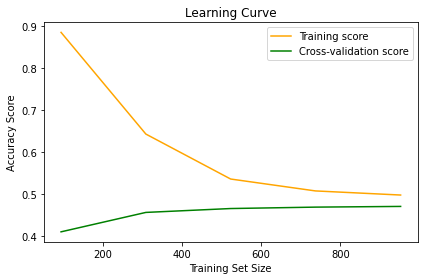




TRAIN ACCURACY: 0.5075566750629723
DEVELOP ACCURACY: 0.4671717171717172


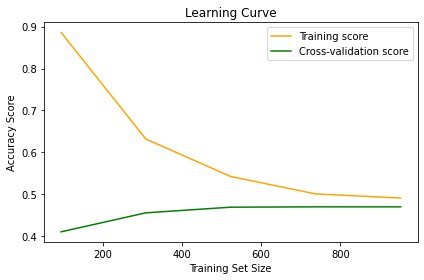




TRAIN ACCURACY: 0.5088161209068011
DEVELOP ACCURACY: 0.4823232323232323


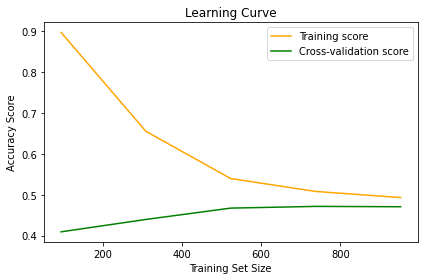




TRAIN ACCURACY: 0.49622166246851385
DEVELOP ACCURACY: 0.5176767676767676


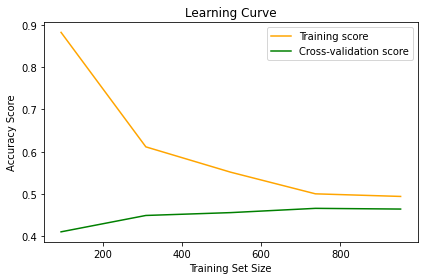




TRAIN ACCURACY: 0.5050377833753149
DEVELOP ACCURACY: 0.45707070707070707


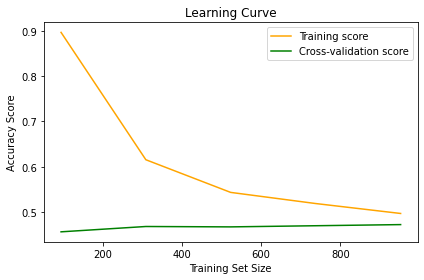




TRAIN ACCURACY: 0.4987405541561713
DEVELOP ACCURACY: 0.4671717171717172


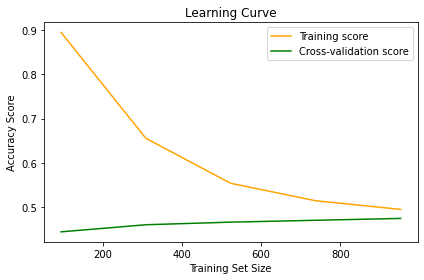




TRAIN ACCURACY: 0.49370277078085645
DEVELOP ACCURACY: 0.4671717171717172


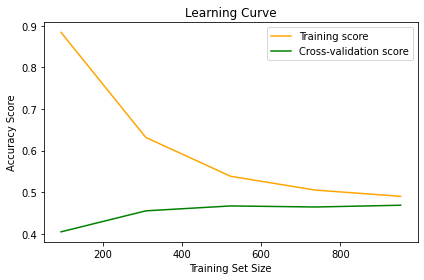




TRAIN ACCURACY: 0.5100755667506297
DEVELOP ACCURACY: 0.45202020202020204


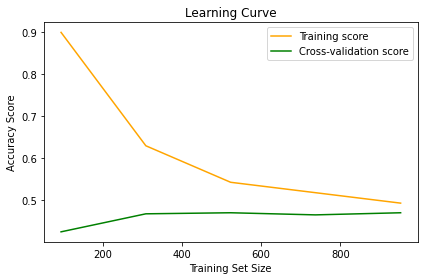




TRAIN ACCURACY: 0.5088161209068011
DEVELOP ACCURACY: 0.4444444444444444


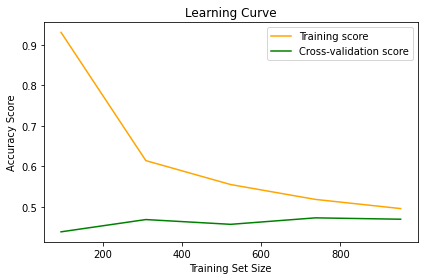




TRAIN ACCURACY: 0.5302267002518891
DEVELOP ACCURACY: 0.4595959595959596


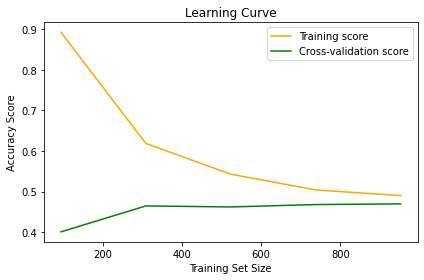

In [222]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

predictions = []
avg_acc_train = []
avg_acc_develop = []

for split in splits:
  y_split_train = split['train'][:, -1]
  y_split_develop = split['develop'][:, -1]
  train = split['train'][:, :-1]
  develop = split['develop'][:, :-1]

  classifier = classifier.fit(train, y_split_train)
  develop_predictions = classifier.predict(develop)
  predictions.append(develop_predictions)
  evaluate = classifier.score(train, y_split_train)
  predict = accuracy_score(develop_predictions, y_split_develop)
  print('\n\n')
  print("TRAIN ACCURACY:", evaluate)
  avg_acc_train.append(evaluate)
  print("DEVELOP ACCURACY:", predict)
  avg_acc_develop.append(predict)
  # if evaluate > predict:
      
  #     if evaluate-predict < 0.1:
  #         print("okay")
  #     else:
  #         print("maybe overfit", evaluate-predict)
  # else:
  #     print("may not be overfit", predict-evaluate)

      

  train_sizes, train_scores, valid_scores = learning_curve(
      RandomForestClassifier(n_estimators=10, max_depth=4, criterion='entropy'),
      np.concatenate((train,develop)), np.concatenate((y_split_train,y_split_develop)), cv=5)


  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)

  test_mean = np.mean(valid_scores, axis=1)
  test_std = np.std(valid_scores, axis=1)


  plt.subplots(1)
  plt.plot(train_sizes, train_mean, color="orange",  label="Training score")
  plt.plot(train_sizes, test_mean, color="g", label="Cross-validation score")

  # plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
  # plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

  plt.title("Learning Curve")
  plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
  plt.tight_layout()
  plt.show()
      

In [223]:
print("Mean TRAIN", np.mean(avg_acc_train))
print("Mean DEVELOP", np.mean(avg_acc_develop))

# a = ['equivalent', 'less intense', 'less specific', 'more intense', 'more specific', 'related']
# prediction_labels = []
# for pred in predictions:
#   prediction_labels.append(pred.argmax(1))

for pred in predictions:
  print(np.unique(pred, return_counts=True))

Mean TRAIN 0.5068010075566751
Mean DEVELOP 0.4702020202020202
(array([0., 3., 4., 5.]), array([  3,   2, 388,   3]))
(array([0., 3., 4., 5.]), array([ 12,   3, 377,   4]))
(array([0., 4., 5.]), array([ 10, 381,   5]))
(array([0., 3., 4., 5.]), array([  5,   4, 386,   1]))
(array([0., 3., 4., 5.]), array([  2,   3, 390,   1]))
(array([0., 3., 4., 5.]), array([  1,   2, 388,   5]))
(array([0., 4., 5.]), array([  1, 394,   1]))
(array([4.]), array([396]))
(array([0., 4., 5.]), array([  6, 388,   2]))
(array([0., 3., 4., 5.]), array([  3,   6, 386,   1]))


In [224]:
test_predictions = classifier.predict(test_corpus_pooled)

In [225]:
test_predictions

array([4., 4., 4., 4., 0., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 3., 3., 4., 3., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4.])

In [226]:
accuracy_score(test_predictions, test_y_encoded)

0.32038834951456313

In [227]:
test_y_encoded

array([4, 4, 0, 3, 4, 5, 0, 4, 0, 0, 3, 4, 3, 3, 4, 2, 0, 4, 5, 4, 1, 5,
       4, 1, 4, 4, 0, 4, 5, 4, 4, 3, 3, 0, 5, 4, 0, 3, 0, 4, 5, 2, 5, 4,
       3, 3, 0, 1, 4, 5, 5, 0, 4, 3, 0, 1, 0, 3, 3, 5, 4, 0, 4, 4, 5, 3,
       0, 5, 0, 2, 3, 0, 4, 4, 5, 0, 0, 4, 2, 5, 5, 4, 4, 4, 0, 0, 2, 3,
       5, 4, 5, 5, 4, 4, 5, 5, 3, 4, 0, 3, 4, 3, 5])